# CS221 Project
**Dawn Finzi and Mona Rosenke**

In [ ]:
#This notebook explores network visualization approaches for 
#the ResNet50 trained on the dermatoscopy imageset

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import h5py

from vis.visualization import visualize_activation
from vis.utils import utils
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay
from keras import activations
from keras import backend as K
from keras.models import load_model

plt.rcParams['figure.figsize'] = (18, 6)

In [6]:
#Let's load the model and data
model = load_model('resnet50.h5')
hf = h5py.File('data.h5', 'r')

In [19]:
#training data
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
#validation data
x_validate = np.array(hf.get('x_validate'))
y_validate = np.array(hf.get('y_validate'))
#testing data
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))

In [18]:
x_train.shape

(7210, 224, 224, 3)

## Feature visualization

In [21]:
#In order to get feature viz to work for the last layer we need
#to switch softmax with linear
layer_idx = utils.find_layer_idx(model, 
                                 'dense_3') #last layer of the model
model.layers[layer_idx].activation = activations.linear #swap activation
model = utils.apply_modifications(model) #reapply to model

In [ ]:
#Let's setup the functions we will need to actually do this
#Inspiration and some code from: 
    #1. https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
    #2. https://fairyonice.github.io/Visualization%20of%20Filters%20with%20Keras.html

In [37]:
#To find the features
def find_images(pic_shape,
                input_img,
                layer_names,
                layer_dict, 
                max_nfmap,
                n_iter=30):
        '''
        Input :

        input_img   : the alias of the input layer from the deep learning model
        layer_names : list containing the name of the layers whose feature maps to be used
        layer_dict  : symbolic outputs of each "key" layer (we gave them unique names).
        max_nfmap   : the maximum number of feature map to be used for each layer.
        
        Output : 
        dictionary 

        key = layer name 
        value = a list containing the tuple of (images, list of loss_values) that maximize each feature map
        '''
        argimage = {}
        ## Look for the image for each feature map of each layer one by one
        for layer_name in layer_names: ## the layer to visualize
            
            ## Find the number of features
            n_fmap = None
            for layer in model.layers:
                if layer.name == layer_name:
                    weights = layer.get_weights()
                    n_fmap=weights[1].shape[0]
            if n_fmap is None:
                print(layer_name + " is not one of the layer names..")
                n_fmap = 1
            n_fmap = np.min([max_nfmap,n_fmap])
            n_fmap = int(n_fmap)
            
            layer_output = layer_dict[layer_name].output
            result = find_images_for_layer(input_img,
                                                layer_output,
                                                range(n_fmap),
                                                n_iter=n_iter)

            argimage[layer_name] = result
            
        return(argimage)

def find_images_for_layer(input_img,
                          layer_output,
                          indicies,
                          n_iter=30):
        '''
        indecies : list containing index of 
                      --> filtermaps of CNN or 
                      --> nodes of fully-connected layer
        Output

        a list containing the tuple of (images, list of loss_values) 
        that maximize each feature map


        '''
        result_temp = []
        for filter_index in indicies: # filtermap to visualize
                iterate = create_iterate(input_img, 
                                         layer_output,
                                         filter_index)
                
                input_img_data = np.random.random((1, 
                                           pic_shape[0],
                                           pic_shape[1],
                                           pic_shape[2]))
            
                step = 500 
                
                # gradient ascent
                loss_values = []
                for i in range(n_iter):
                    loss_value, grads_value = iterate([input_img_data, 0])
                    input_img_data += grads_value * step
                    loss_values.append(loss_value)              
                
                result_temp.append((input_img_data,loss_values))
         
        return(result_temp)
    
def create_iterate(input_img, layer_output,filter_index):
        '''
        layer_output[:,:,:,0] is (Nsample, 94, 94) tensor contains:
        W0^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        layer_output[:,:,:,1] contains:
        W1^T [f(image)]_{i,j}], i = 1,..., 94, j = 1,..., 94
        
        W0 and W1 are different kernel!
        '''
        ## loss is a scalar 
        if len(layer_output.shape) == 4:
            ## conv layer 
            loss = K.mean(layer_output[:,  :, :, filter_index])
        elif len(layer_output.shape) ==2:
            ## fully connected layer
            loss = K.mean(layer_output[:, filter_index])
         
        # calculate the gradient of the loss evaluated at the provided image
        grads = K.gradients(loss, input_img)[0]
        # normalize the gradients
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # iterate is a function taking (input_img, scalar) and output [loss_value, gradient_value]
        iterate = K.function([input_img, K.learning_phase()], [loss, grads])
        return(iterate)

In [38]:
#To actually plot the images
def deprocess_image(x):
    # normalize tensor: mean 0 and std 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # shift mean to 0.5
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

def plot_images_wrapper(pic_shape,argimage,n_row = 8, scale = 1):
        '''
        scale : scale up or down the plot size
        '''

        if pic_shape[2] == 1:
            pic_shape = self.pic_shape[:2]
        layer_names = np.sort(argimage.keys())


        for layer_name in layer_names:
            n_fmap = len(argimage[layer_name])
            n_col = np.ceil(n_fmap/float(n_row))
            fig = plt.figure(figsize=(n_col*scale,
                                      n_row*scale))
            fig.subplots_adjust(hspace=0.001,wspace=0.001)
            plt.title(layer_name + " n_featuremap=" + str(n_fmap))
            count = 1
            for value in argimage[layer_name]:
                input_img_data = value[0][0]
                img = deprocess_image(input_img_data)
                ax = fig.add_subplot(n_row,n_col,count,
                                    xticks=[],yticks=[])
                ax.imshow(img.reshape(*pic_shape),cmap="gray")
                count += 1
            plt.show()

In [46]:
#Create input, layer dict and pick layers to visualize
input_img = model.layers[0].input
layer_dict = dict([(layer.name, layer) 
                   for layer in model.layers])

layer_names = ["conv1",
               "res2a_branch2a",
               "res2b_branch2a",
               "res2c_branch2a",
               "res3a_branch2a",
               "res3b_branch2a",
               "res3c_branch2a",
               "res3d_branch2a",
               "res4a_branch2a",
               "res4b_branch2a",
               "res4c_branch2a",
               "res4d_branch2a",
               "res4e_branch2a",
               "res4f_branch2a",
               "res5a_branch2a",
               "res5b_branch2a",
               "res5c_branch2c"]

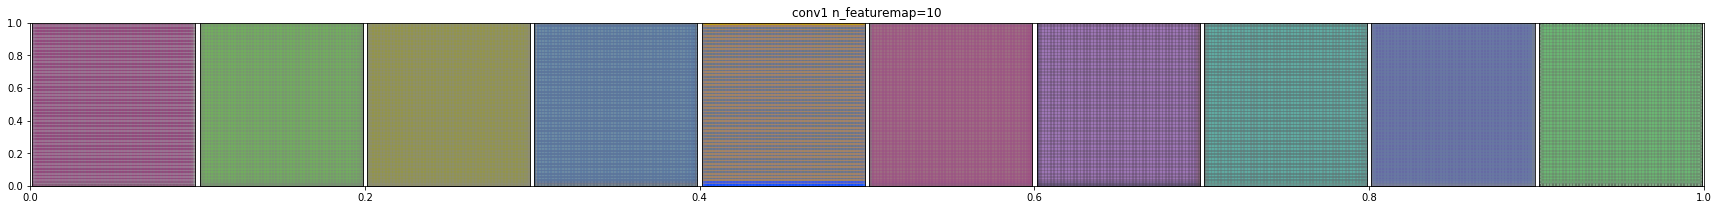

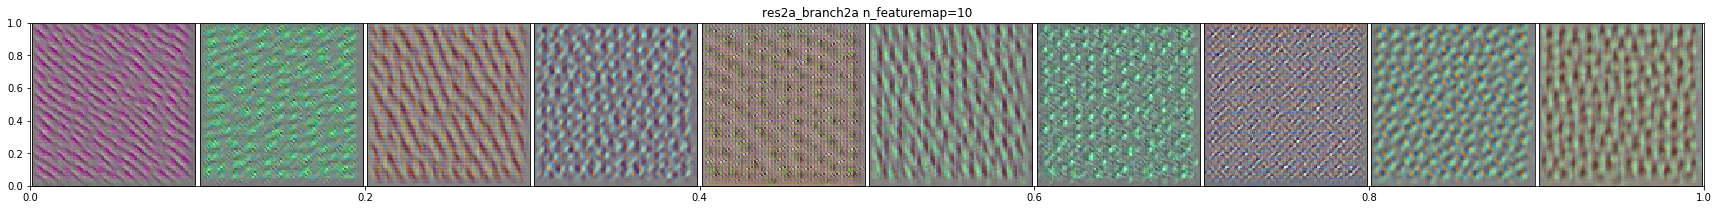

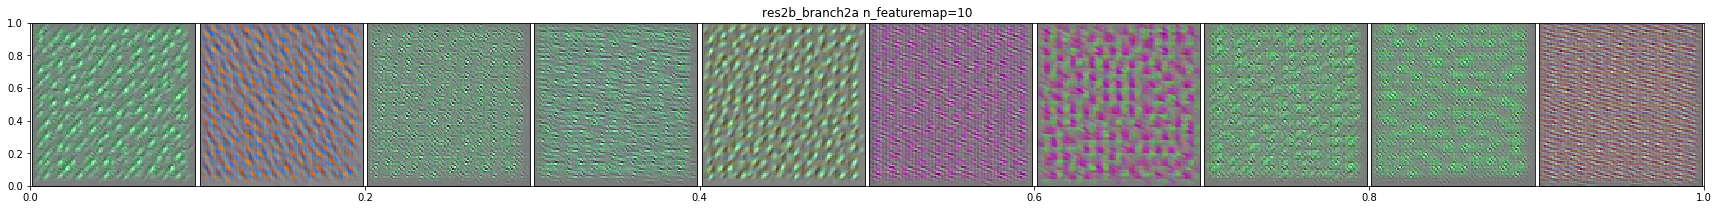

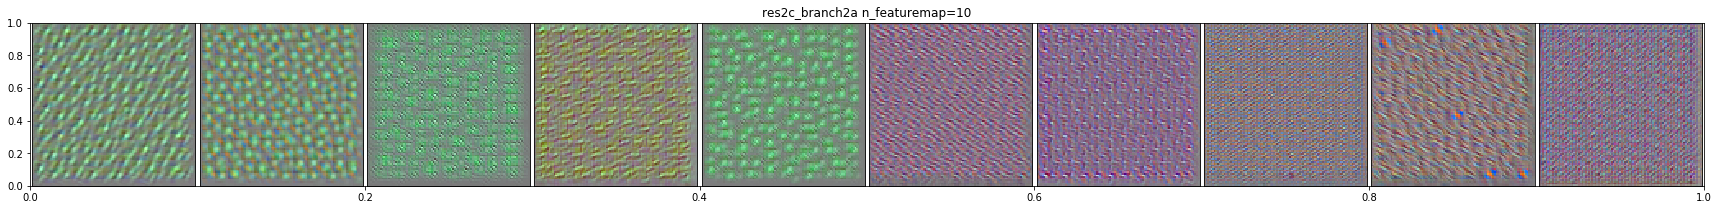

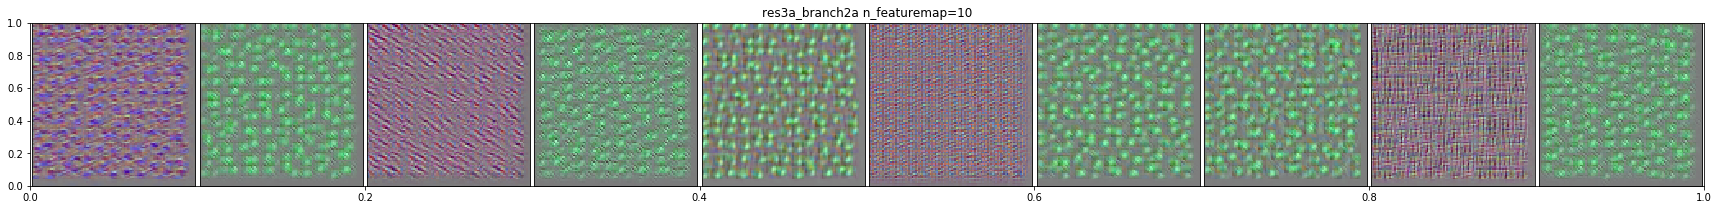

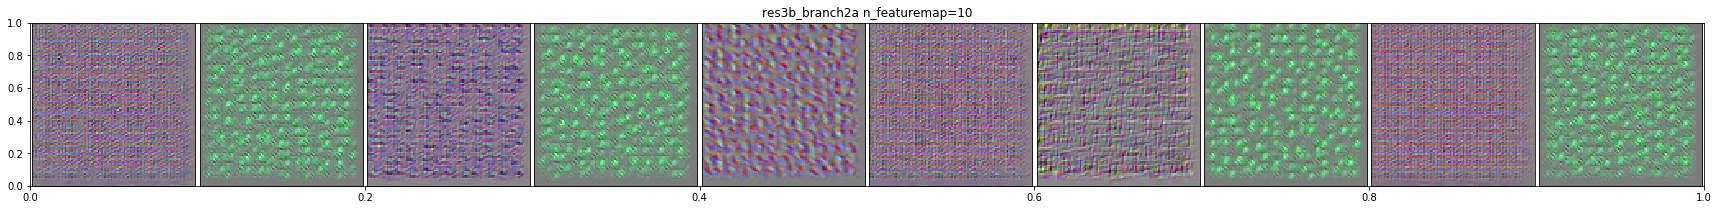

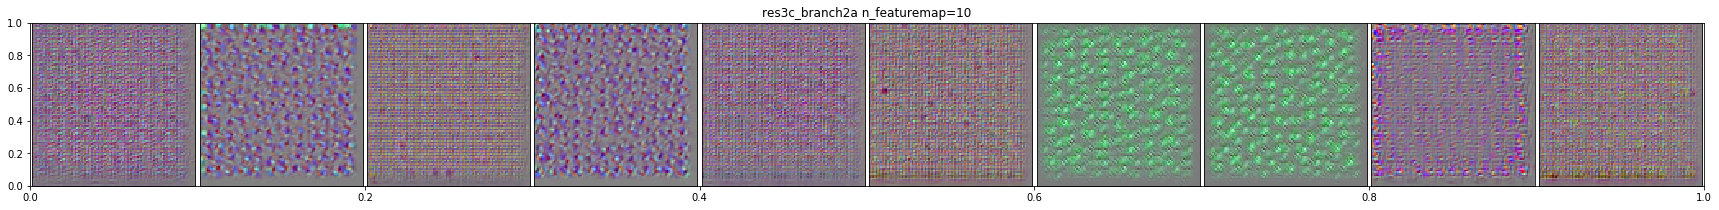

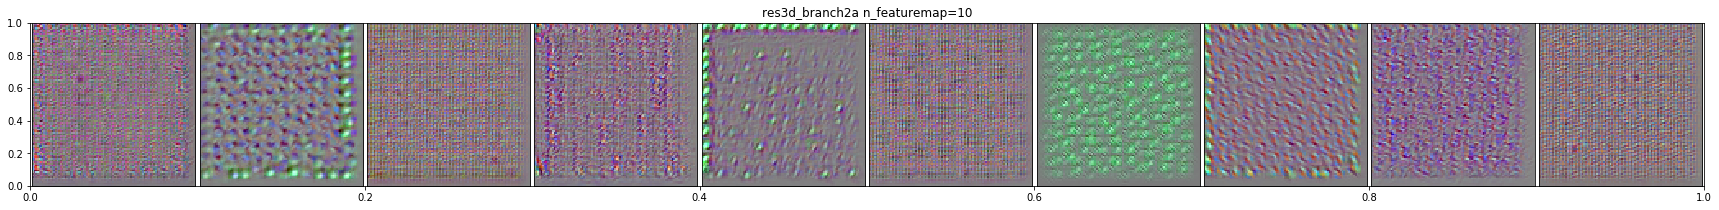

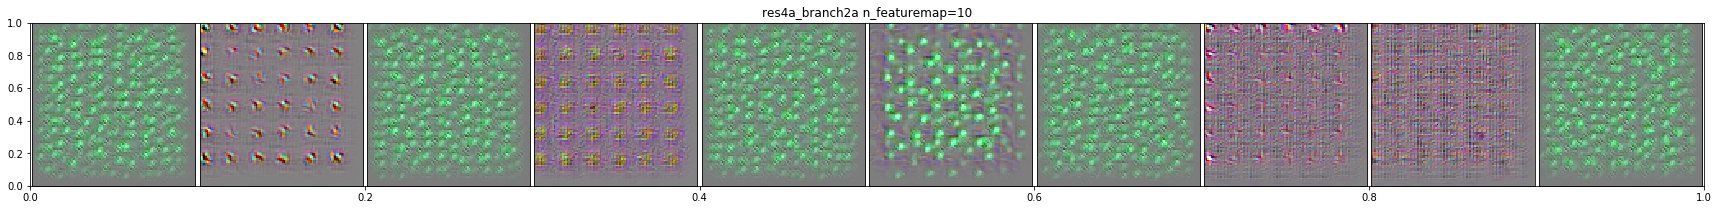

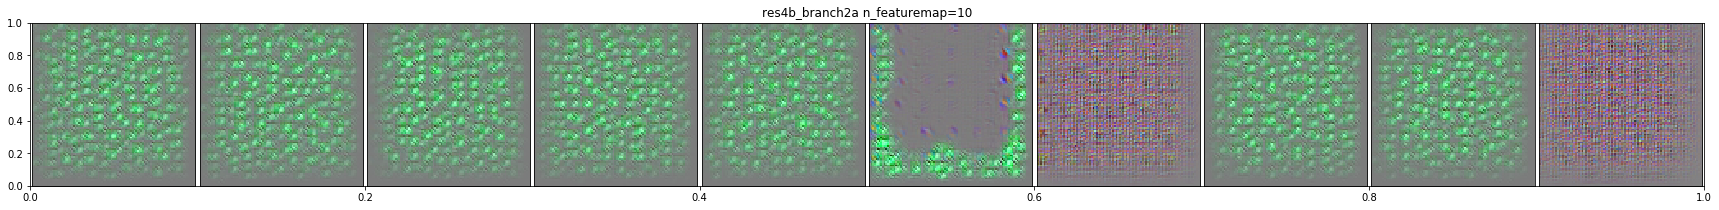

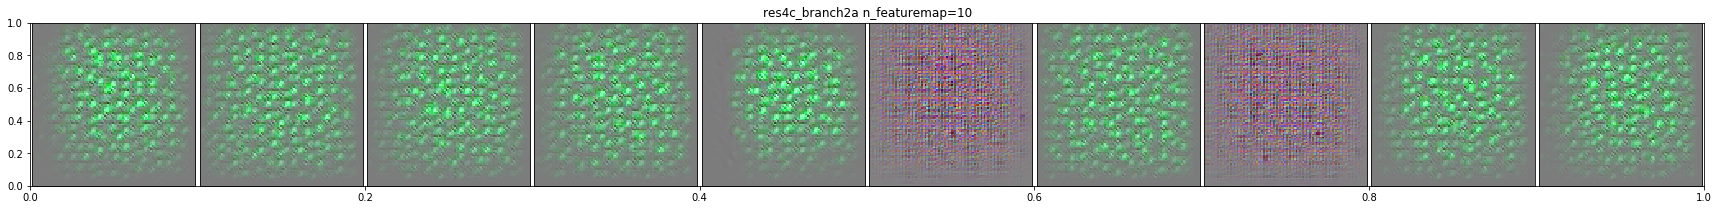

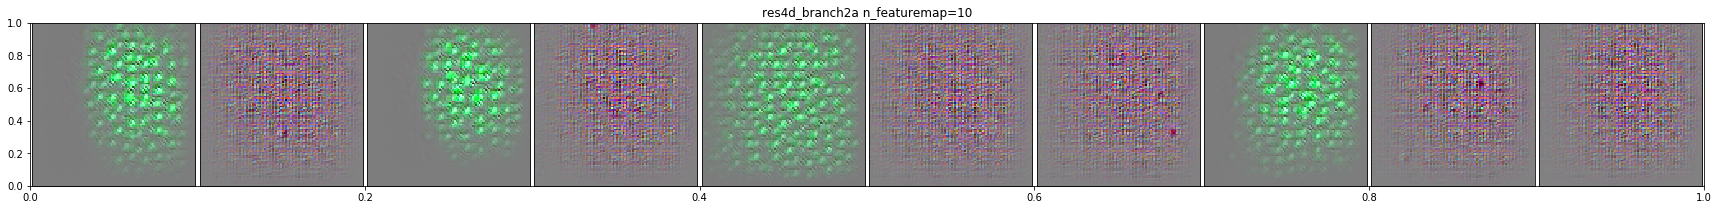

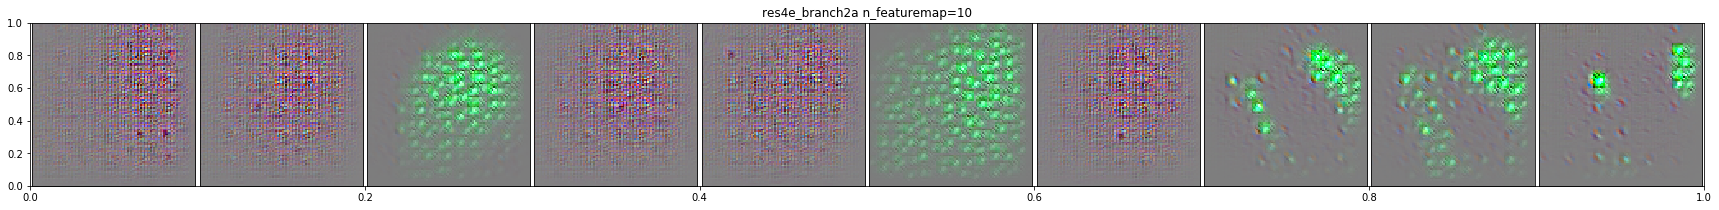

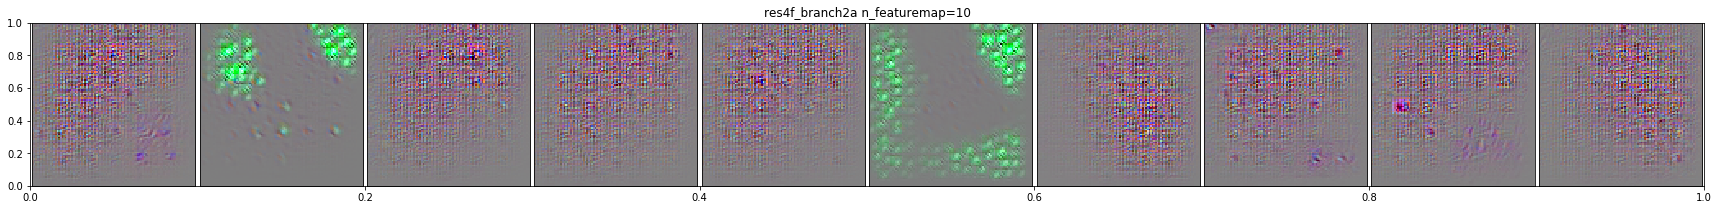

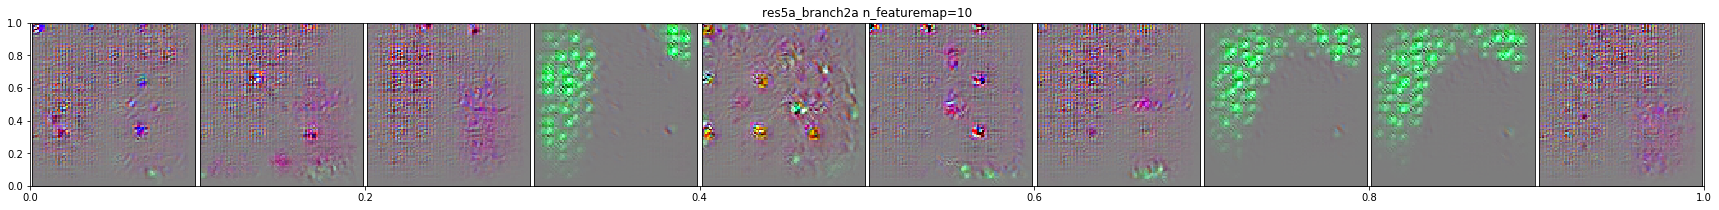

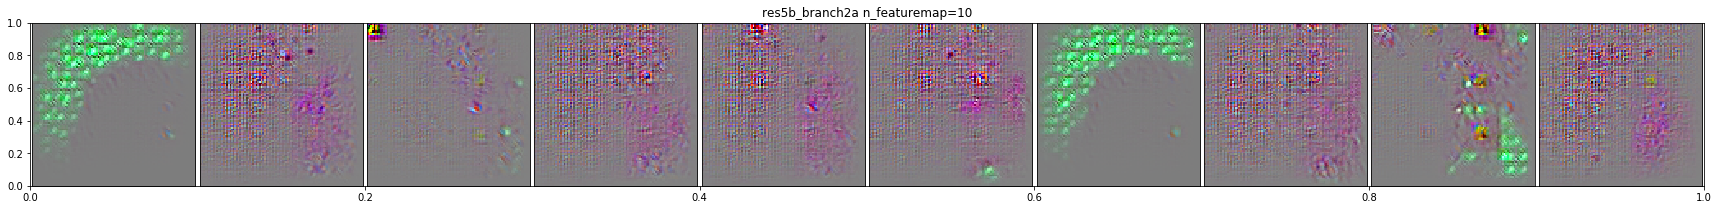

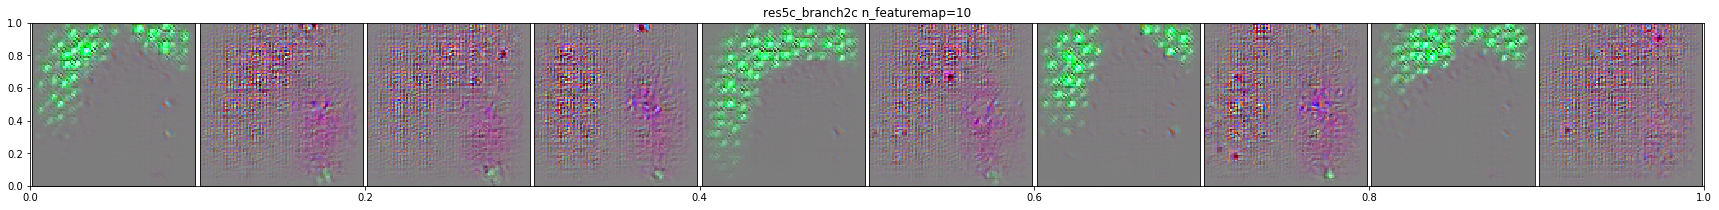

In [47]:
pic_shape = (100,100,3)
max_nfmap = 10
argimage = find_images(pic_shape,
                       input_img,
                       layer_names,
                       layer_dict,
                       max_nfmap)
plot_images_wrapper(pic_shape,
                    argimage, 
                    n_row = 1, 
                    scale = 3)

## Saliency maps

In [ ]:
#Reload the model so we're back to softmax activation
model = load_model('resnet50.h5')

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


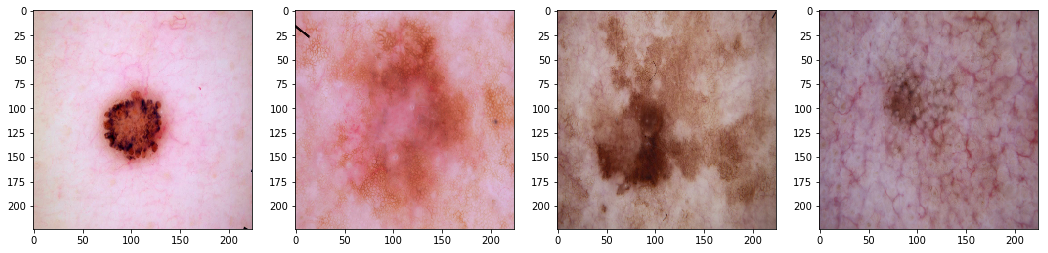

In [42]:
#Let's start with some example melanomas
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('../data/HAM10000_images/ISIC_0030653.jpg', 
                      target_size=(224, 224))
img2 = utils.load_img('../data/HAM10000_images/ISIC_0027101.jpg',
                      target_size=(224, 224))
img3 = utils.load_img('../data/HAM10000_images/ISIC_0025195.jpg',
                      target_size=(224, 224))
img4 = utils.load_img('../data/HAM10000_images/ISIC_0029893.jpg',
                      target_size=(224, 224))
f, ax = plt.subplots(1, 4)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
ax[3].imshow(img4)

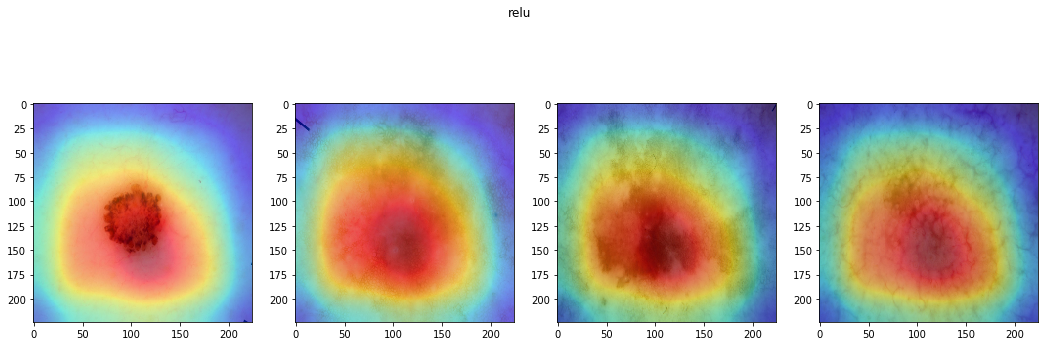

In [48]:
#Can we use gradCAM to visualize network "attention"?
filter_idx = 5 #melanoma = 5

#can't use the last layer for gradCAM - using penultimate instead
penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')

for modifier in ['relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2, img3, img4]):    
        grads = visualize_cam(model, 
                              layer_idx, 
                              filter_indices=filter_idx, # 5 is the index for melanoma
                              seed_input=img, 
                              penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

In [49]:
#hmm not sure that really worked

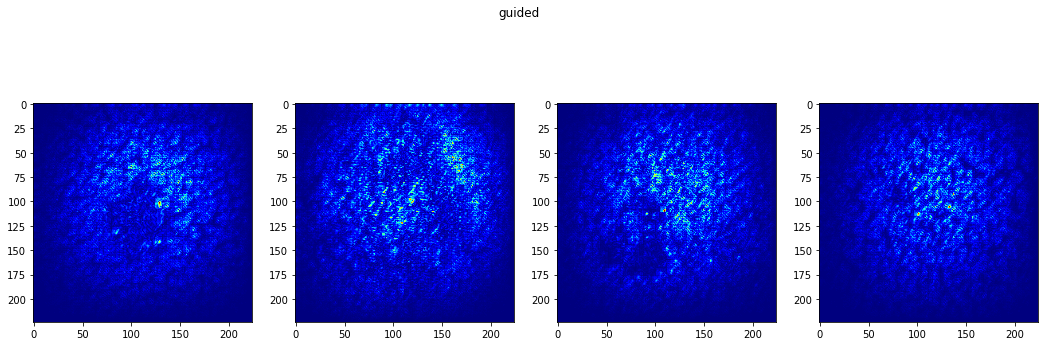

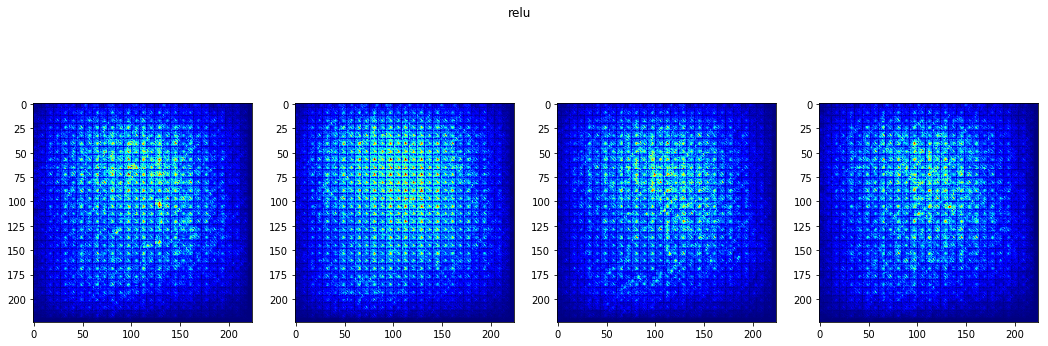

In [50]:
#let's try saliency instead? maybe this will allow better visualization

#gotta change the layer back to the last layer
layer_idx = utils.find_layer_idx(model, 'dense_3')

for modifier in ['guided', 'relu']: #let's try 2 approaches
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2,img3,img4]):    
        grads = visualize_saliency(model, 
                                   layer_idx, 
                                   filter_indices=filter_idx, 
                                   seed_input=img, 
                                   backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

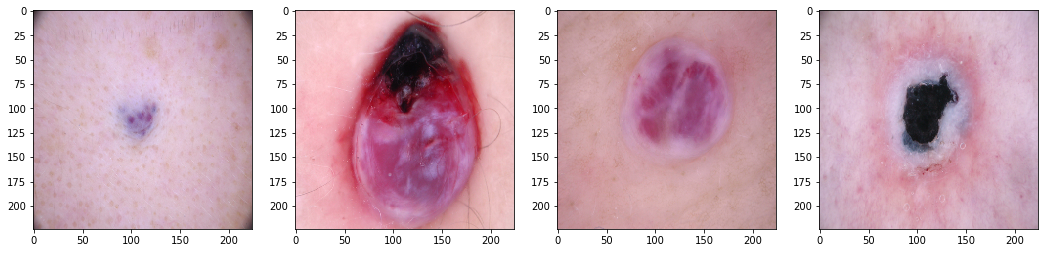

In [51]:
#what about something smaller and benign like vascular lesions?
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('../data/HAM10000_images/ISIC_0029514.jpg', 
                      target_size=(224, 224))
img2 = utils.load_img('../data/HAM10000_images/ISIC_0033254.jpg',
                      target_size=(224, 224))
img3 = utils.load_img('../data/HAM10000_images/ISIC_0033349.jpg',
                      target_size=(224, 224))
img4 = utils.load_img('../data/HAM10000_images/ISIC_0033749.jpg',
                      target_size=(224, 224))
f, ax = plt.subplots(1, 4)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
ax[3].imshow(img4)

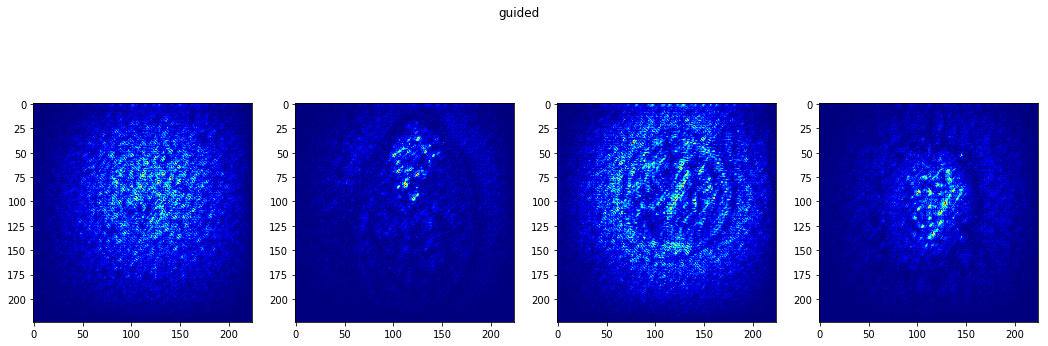

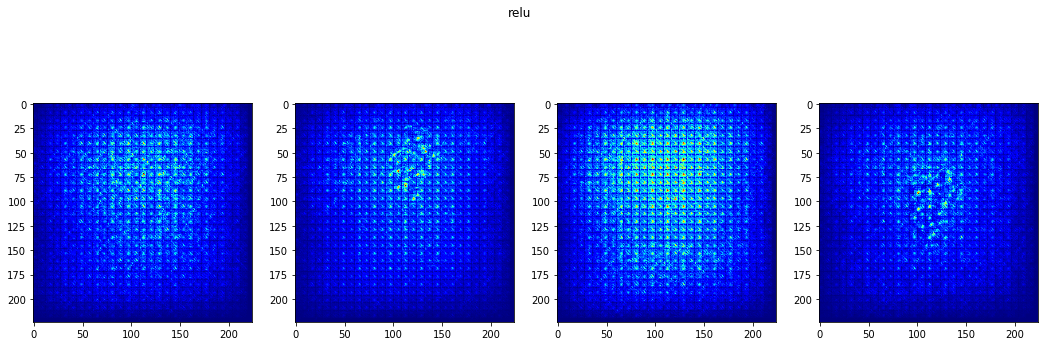

In [52]:
filter_idx = 6 #vascular lesions = 6
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2,img3,img4]):    
        grads = visualize_saliency(model, 
                                   layer_idx, 
                                   filter_indices=6, 
                                   seed_input=img, 
                                   backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')